<a href="https://colab.research.google.com/github/mofuoku417/Machine-Learning-Techniques-for-Multivariate-Time-Series-Forecasting-of-Crude-Palm-Oil-Prices/blob/main/MV_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Objective: Predict Monthly Crude Palm Oil Price Using Convolutional Neural Network (CNN)

In [1]:
!pip install scikeras
!pip install bayesian-optimization
!pip install keras-tuner --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 135 kB 32.3 MB/s 
     |████████████████████████████████| 1.6 MB 51.2 MB/s 


###Load Libraries

In [2]:
from numpy.random import seed
seed(1)
import tensorflow as tf
tf.random.set_seed(1)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['figure.figsize'] = (10, 5)
plt.style.use('fivethirtyeight')
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import tensorflow as tf
from tensorflow.keras import layers
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import make_scorer, mean_squared_error
from keras.layers import Dense, Dropout
from sklearn.metrics import explained_variance_score
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import warnings
warnings.filterwarnings('ignore')
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import KFold, cross_val_score
from scikeras.wrappers import KerasRegressor
from tensorflow import keras
from kerastuner.tuners import RandomSearch
from kerastuner import HyperModel, RandomSearch, Hyperband, BayesianOptimization
from keras.callbacks import EarlyStopping
from time import time
import pickle

import matplotlib.dates as mdates
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler

###Define Functions to Facilitate Metrics Evaluation

In [3]:
#To compute Mean Directional Accuracy
def mda(actual: np.ndarray, predicted: np.ndarray):
    """ Mean Directional Accuracy """
    return np.mean((np.sign(actual[1:] - actual[:-1]) == np.sign(predicted[1:] - predicted[:-1])).astype(int))

#Calculate the Mean Absolute Percentage Error
#def MAPE(y_true, y_pred): 
    #mape = np.mean(np.abs((np.array(y_true) - np.array(y_pred)) / np.array(y_true))) * 100
    #return mape

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def MAPE(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

#Calculate the Root Mean Squared Error:
def RMSE(y_true, y_pred): 
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    return rmse

###Load the Cleaned Data from Github

In [9]:
from pandas import read_csv
path = 'https://raw.githubusercontent.com/mofuoku417/Machine-Learning-Techniques-for-Multivariate-Time-Series-Forecasting-of-Crude-Palm-Oil-Prices/main/Cleaned_data/FS_2.csv'
df = read_csv(path)
df.head()

,date,cpo_pri,cno_pri,oli_pri,rps_pri,pno_pri,sbo_pri,sfo_pri
0,12/1/10,323,455,3102.61,423.45,844.0,468.0,578.0
1,1/1/11,345,546,3100.45,415.85,799.0,485.0,557.0
2,2/1/11,362,595,3199.41,410.77,718.0,466.0,552.0
3,3/1/11,376,636,3281.67,414.82,614.0,442.0,574.0
4,4/1/11,383,738,3261.65,451.04,619.0,429.0,595.0


In [10]:
df['date']=pd.to_datetime(df['date'])
#del df['date']

In [11]:
df.set_index('date', inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 124 entries, 2010-12-01 to 2021-03-01
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   cpo_pri  124 non-null    int64  
 1   cno_pri  124 non-null    int64  
 2   oli_pri  124 non-null    float64
 3   rps_pri  124 non-null    float64
 4   pno_pri  124 non-null    float64
 5   sbo_pri  124 non-null    float64
 6   sfo_pri  124 non-null    float64
dtypes: float64(5), int64(2)
memory usage: 7.8 KB


In [12]:
df.head()

,cpo_pri,cno_pri,oli_pri,rps_pri,pno_pri,sbo_pri,sfo_pri
date,,,,,,,
2010-12-01,323,455,3102.61,423.45,844.0,468.0,578.0
2011-01-01,345,546,3100.45,415.85,799.0,485.0,557.0
2011-02-01,362,595,3199.41,410.77,718.0,466.0,552.0
2011-03-01,376,636,3281.67,414.82,614.0,442.0,574.0
2011-04-01,383,738,3261.65,451.04,619.0,429.0,595.0


<Figure size 1800x720 with 0 Axes>

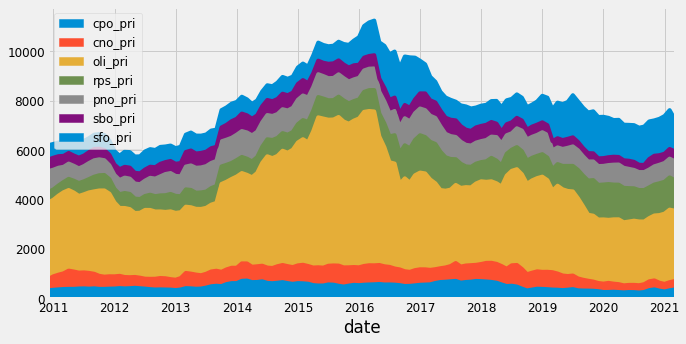

In [13]:
# Plot an area chart
plt.figure(figsize=(25,10))
ax = df.plot.area(fontsize=12);

# Additional customizations
ax.set_xlabel('date');
ax.legend(fontsize=12);

##**Convolutional Neural Network Forecasting Technique (CNN)**

###**Split Data into Train Test Segments**

In [14]:
train_size = int(len(df) * 0.8)
test_size = len(df) - train_size
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
print('Train size:',len(train))
print('Test size:', len(test))

Train size: 99
Test size: 25


In [15]:
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
print(len(train), len(test))

99 25


In [16]:
print(train.shape)
train.head()

(99, 7)


,cpo_pri,cno_pri,oli_pri,rps_pri,pno_pri,sbo_pri,sfo_pri
date,,,,,,,
2010-12-01,323,455,3102.61,423.45,844.0,468.0,578.0
2011-01-01,345,546,3100.45,415.85,799.0,485.0,557.0
2011-02-01,362,595,3199.41,410.77,718.0,466.0,552.0
2011-03-01,376,636,3281.67,414.82,614.0,442.0,574.0
2011-04-01,383,738,3261.65,451.04,619.0,429.0,595.0


###Rescaling Training Data

In [17]:
f_transformer = MinMaxScaler()
feature_columns = ['cno_pri', 'oli_pri', 'rps_pri', 'pno_pri', 'sbo_pri', 'sfo_pri']
f_transformer = f_transformer.fit(train[feature_columns].to_numpy())
train.loc[:, feature_columns] = f_transformer.transform(train[feature_columns].to_numpy())
train.head()

,cpo_pri,cno_pri,oli_pri,rps_pri,pno_pri,sbo_pri,sfo_pri
date,,,,,,,
2010-12-01,323,0.112288,0.140918,0.010736,0.528090,0.253193,0.023302
2011-01-01,345,0.305085,0.140327,0.004301,0.443820,0.306536,0.009321
2011-02-01,362,0.408898,0.167408,0.000000,0.292135,0.246917,0.005992
2011-03-01,376,0.495763,0.189919,0.003429,0.097378,0.171609,0.020639
2011-04-01,383,0.711864,0.184440,0.034095,0.106742,0.130817,0.034621


In [18]:
cpo_pri_transformer = MinMaxScaler()
cpo_pri_transformer = cpo_pri_transformer.fit(train[['cpo_pri']])
train['cpo_pri'] = cpo_pri_transformer.transform(train[['cpo_pri']])
train['cpo_pri'].head()

date
2010-12-01    0.0100
2011-01-01    0.0650
2011-02-01    0.1075
2011-03-01    0.1425
2011-04-01    0.1600
Name: cpo_pri, dtype: float64

In [19]:
test.loc[:, feature_columns] = f_transformer.transform(test[feature_columns].to_numpy())
test.head()

,cpo_pri,cno_pri,oli_pri,rps_pri,pno_pri,sbo_pri,sfo_pri
date,,,,,,,
2019-03-01,354,0.637712,0.194855,0.382454,0.381292,-0.039662,0.493342
2019-04-01,348,0.533898,0.264388,0.393951,0.213633,-0.054975,0.597870
2019-05-01,332,0.400424,0.246417,0.453802,0.235262,-0.092159,0.606525
2019-06-01,349,0.317797,0.234308,0.509834,0.320749,-0.074743,0.631824
2019-07-01,372,0.313559,0.223422,0.526454,0.426610,-0.066114,0.773462


In [20]:
test['cpo_pri'] = cpo_pri_transformer.transform(test[['cpo_pri']])
test['cpo_pri'].head()

date
2019-03-01    0.0875
2019-04-01    0.0725
2019-05-01    0.0325
2019-06-01    0.0750
2019-07-01    0.1325
Name: cpo_pri, dtype: float64

###Create X_train, y_train, X_test and y_test

In [57]:
def createDataset(X, y, time_steps):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        data = X.iloc[i:(i + time_steps)].values
        Xs.append(data)        
        ys.append(y.iloc[i + time_steps])
        
    return np.array(Xs), np.array(ys)

time_steps = 3
X_train, y_train = createDataset(train, train.cpo_pri, time_steps)
X_test, y_test = createDataset(test, test.cpo_pri, time_steps)
print(X_train.shape, y_train.shape)

(96, 3, 7) (96,)


In [ ]:
#test_lag = test[1:23]
#len(test) - 1

In [ ]:
#decrement naturally.
#shifted = test.set_index(["date"]).unstack().shift(3).stack()

In [64]:
cnn_model = tf.keras.Sequential()
cnn_model.add(tf.keras.layers.Conv1D(filters=64, kernel_size=2, activation='tanh', input_shape=(X_test.shape[1], X_test.shape[2])))
cnn_model.add(tf.keras.layers.MaxPooling1D(pool_size=2))
cnn_model.add(tf.keras.layers.Flatten())
cnn_model.add(tf.keras.layers.Dense(64, activation='tanh'))
cnn_model.add(tf.keras.layers.Dense(1, 'linear'))

# compile model using adam
cnn_model.compile(optimizer='adam',loss='mse',metrics=['mse'])
# model training
history = cnn_model.fit(X_train, y_train, epochs=300, batch_size = 128, validation_split=0.2) #epochs = 30, batch_size = 60

# model evaluation
cnn_model.evaluate(X_test, y_test)


#cnn_model.compile(loss='mse', optimizer='adam')
#cnn_model.summary()
#bst -> epochs = 300, batch_size = 128, RMSE = 32
#bst -> epochs = 350, batch_size = 100, RMSE = 36
#bst -> epochs = 400, batch_size = 128, RMSE = 39

Epoch 1/300
1/1 [==============================] - 1s 593ms/step - loss: 0.3976 - mse: 0.3976 - val_loss: 0.2252 - val_mse: 0.2252
Epoch 2/300
1/1 [==============================] - 0s 27ms/step - loss: 0.2199 - mse: 0.2199 - val_loss: 0.1040 - val_mse: 0.1040
Epoch 3/300
1/1 [==============================] - 0s 25ms/step - loss: 0.0990 - mse: 0.0990 - val_loss: 0.0455 - val_mse: 0.0455
Epoch 4/300
1/1 [==============================] - 0s 44ms/step - loss: 0.0331 - mse: 0.0331 - val_loss: 0.0417 - val_mse: 0.0417
Epoch 5/300
1/1 [==============================] - 0s 27ms/step - loss: 0.0157 - mse: 0.0157 - val_loss: 0.0750 - val_mse: 0.0750
Epoch 6/300
1/1 [==============================] - 0s 26ms/step - loss: 0.0327 - mse: 0.0327 - val_loss: 0.1188 - val_mse: 0.1188
Epoch 7/300
1/1 [==============================] - 0s 33ms/step - loss: 0.0624 - mse: 0.0624 - val_loss: 0.1499 - val_mse: 0.1499
Epoch 8/300
1/1 [==============================] - 0s 28ms/step - loss: 0.0850 - mse: 0.0

[0.01690441183745861, 0.01690441183745861]

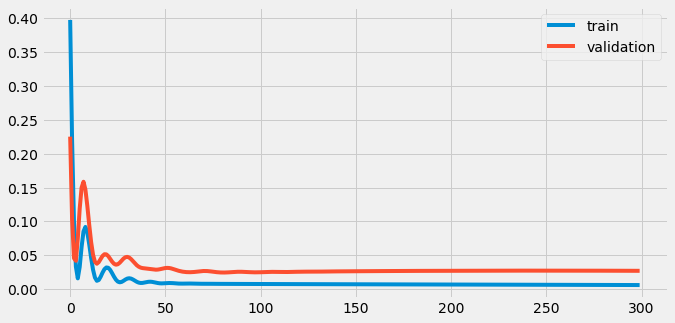

In [67]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.show()

In [68]:
mse_cnn = cnn_model.evaluate(X_test, y_test)

1/1 [==============================] - 0s 20ms/step - loss: 0.0169 - mse: 0.0169


####Baseline MSE = 0.0169

In [69]:
cnn_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 2, 64)             960       
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 1, 64)            0         
 1D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 64)                0         
                                                                 
 dense_9 (Dense)             (None, 64)                4160      
                                                                 
 dense_10 (Dense)            (None, 1)                 65        
                                                                 
Total params: 5,185
Trainable params: 5,185
Non-trainable params: 0
____________________________________________________

###Predict the Test without Hyperparameter Tuning

In [70]:
y_pred = cnn_model.predict(X_test)
y_pred

1/1 [==============================] - 0s 57ms/step


array([[ 0.09477703],
       [ 0.09873489],
       [ 0.12301685],
       [ 0.11723491],
       [ 0.13253102],
       [ 0.10627772],
       [ 0.0976567 ],
       [ 0.04862951],
       [-0.01441155],
       [-0.03395047],
       [-0.05177804],
       [-0.02480905],
       [-0.03990883],
       [-0.0330333 ],
       [-0.04474574],
       [-0.08742907],
       [-0.08945786],
       [ 0.00957403],
       [ 0.10102498],
       [ 0.09531772],
       [ 0.00234727],
       [ 0.01293722]], dtype=float32)

In [71]:
y_pred.reshape(1,-1)

array([[ 0.09477703,  0.09873489,  0.12301685,  0.11723491,  0.13253102,
         0.10627772,  0.0976567 ,  0.04862951, -0.01441155, -0.03395047,
        -0.05177804, -0.02480905, -0.03990883, -0.0330333 , -0.04474574,
        -0.08742907, -0.08945786,  0.00957403,  0.10102498,  0.09531772,
         0.00234727,  0.01293722]], dtype=float32)

###Invert Transformed Data

In [72]:
y_train_inv = cpo_pri_transformer.inverse_transform(y_train.reshape(1, -1))
y_test_inv = cpo_pri_transformer.inverse_transform(y_test.reshape(1, -1))
y_pred_inv = cpo_pri_transformer.inverse_transform(y_pred.reshape(1,-1))
print(y_train_inv)
print(y_test_inv)
print(y_pred_inv)

[[376. 383. 382. 396. 402. 390. 404. 382. 382. 391. 396. 413. 401. 410.
  425. 408. 392. 371. 356. 362. 356. 352. 333. 357. 411. 404. 387. 395.
  434. 488. 508. 494. 575. 614. 616. 707. 719. 655. 661. 687. 625. 611.
  631. 655. 616. 586. 615. 607. 590. 535. 518. 519. 562. 552. 508. 476.
  513. 545. 532. 550. 561. 567. 580. 559. 562. 553. 533. 498. 504. 525.
  547. 556. 566. 621. 659. 671. 688. 705. 633. 661. 674. 703. 694. 681.
  663. 632. 561. 497. 509. 475. 392. 319. 354. 388. 381. 370.]]
[[349. 372. 324. 315. 312. 306. 288. 255. 257. 265. 254. 240. 254. 251.
  234. 255. 330. 362. 310. 277. 323. 360.]]
[[356.9108  358.49396 368.20673 365.89395 372.0124  361.51108 358.06268
  338.4518  313.23538 305.4198  298.2888  309.0764  303.03647 305.78668
  301.1017  284.02835 283.21686 322.8296  359.41    357.1271  319.9389
  324.17487]]


###Plot History, Actual and Predicted Value

In [73]:
y_train_inv = y_train_inv.flatten()
y_train_inv

array([376., 383., 382., 396., 402., 390., 404., 382., 382., 391., 396.,
       413., 401., 410., 425., 408., 392., 371., 356., 362., 356., 352.,
       333., 357., 411., 404., 387., 395., 434., 488., 508., 494., 575.,
       614., 616., 707., 719., 655., 661., 687., 625., 611., 631., 655.,
       616., 586., 615., 607., 590., 535., 518., 519., 562., 552., 508.,
       476., 513., 545., 532., 550., 561., 567., 580., 559., 562., 553.,
       533., 498., 504., 525., 547., 556., 566., 621., 659., 671., 688.,
       705., 633., 661., 674., 703., 694., 681., 663., 632., 561., 497.,
       509., 475., 392., 319., 354., 388., 381., 370.])

In [74]:
y_test_inv = y_test_inv.flatten()
y_test_inv

array([349., 372., 324., 315., 312., 306., 288., 255., 257., 265., 254.,
       240., 254., 251., 234., 255., 330., 362., 310., 277., 323., 360.])

In [75]:
y_pred_inv = y_pred_inv.flatten()
y_pred_inv

array([356.9108 , 358.49396, 368.20673, 365.89395, 372.0124 , 361.51108,
       358.06268, 338.4518 , 313.23538, 305.4198 , 298.2888 , 309.0764 ,
       303.03647, 305.78668, 301.1017 , 284.02835, 283.21686, 322.8296 ,
       359.41   , 357.1271 , 319.9389 , 324.17487], dtype=float32)

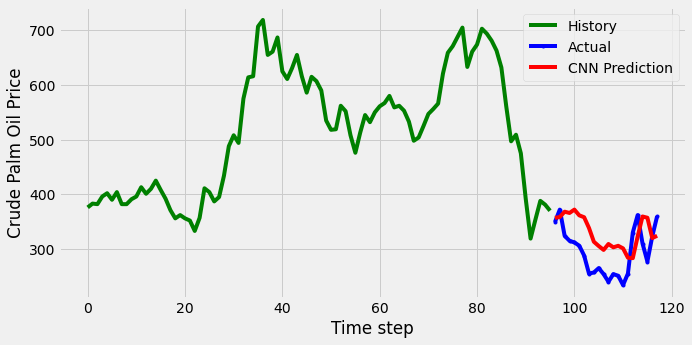

In [76]:
plt.plot(np.arange(0, len(y_train)), y_train_inv, color='green', label="History")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test_inv, color='blue', marker='.', label="Actual")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_pred_inv, color='red', label="CNN Prediction")
plt.ylabel('Crude Palm Oil Price')
plt.xlabel('Time step')
plt.legend()
plt.show();

###Evaluate CNN Model Accuracy

In [77]:
MAE_cnn = mean_absolute_error(y_test_inv, y_pred_inv)
print('MAE value of the CNN Model is:', MAE_cnn)

MDA_cnn = mda(y_test_inv, y_pred_inv)
print('MDA value of the CNN Model is:', MDA_cnn)

MAPE_cnn = mean_absolute_percentage_error(y_test_inv, y_pred_inv)
print('MAPE value of the CNN Model is:', MAPE_cnn)

RMSE_cnn = mean_squared_error(y_test_inv,y_pred_inv, squared=False)
print('RMSE value of the CNN Model is:', RMSE_cnn)

MSE_cnn = mean_squared_error(y_test_inv,y_pred_inv)
print('MSE value of the CNN Model is:', MSE_cnn)

#EVS_cnn = explained_variance_score(y_test_inv, y_pred_inv)
#print('EVS score of the CNN Model is:', EVS_cnn)

MAE value of the CNN Model is: 47.722997492009945
MDA value of the CNN Model is: 0.47619047619047616
MAPE value of the CNN Model is: 17.065203605182834
RMSE value of the CNN Model is: 52.006788432860596
MSE value of the CNN Model is: 2704.706043100323


####Actual VS Predicted CNN Model

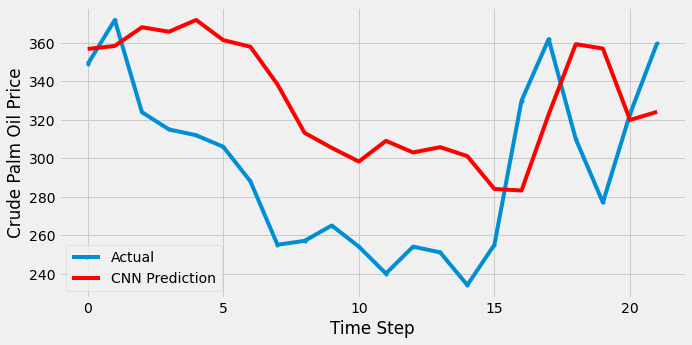

In [78]:
plt.plot(y_test_inv, marker='.', label="Actual")
plt.plot(y_pred_inv, color='red', label="CNN Prediction")
plt.ylabel('Crude Palm Oil Price')
plt.xlabel('Time Step')
plt.legend()
plt.show();

###Tuning CNN with Keras Tuner

In [81]:
class ANNhypermodel(HyperModel):
#class CNNHyperModel(HyperModel):
    
    def __init__(self, input_shape):
        self.input_shape= input_shape
        
    def build(self, hp):
        model= keras.Sequential()
        
        # Tune the number of units in the first Dense layer
        # Defining dense units as a close approx to the original neural network to perform a fair comparision!
        
        
        hp_units_1= hp.Int('units_1', min_value=128, max_value= 160, step=32)
        hp_units_2= hp.Int('units_2', min_value=64, max_value= 128, step=32)
        hp_units_3= hp.Int('units_3', min_value=32, max_value= 64, step=16)

        model.add(keras.layers.Dense(units=hp_units_1, activation='tanh', input_shape= self.input_shape))
        model.add(keras.layers.Dense(units=hp_units_2, activation='tanh'))
        model.add(keras.layers.Dense(units=hp_units_3, activation='tanh'))
        model.add(keras.layers.Dense(1))

        #Tune the dropout
        model.add(
            Dropout(
                rate=hp.Float(
                    'dropout',
                    min_value=0.0,
                    max_value=0.5,
                    default=0.25,
                    step=0.05
                )
            )
        )

        # Tune the learning rate for the optimizer 
        hp_learning_rate=hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG', default= 0.0005)
       # -------------------------------------------------------
        #model.add(
            #layers.Dense(
                #hp.Float(
                    #'batch_size',
                    #'type": "range', ###########
                     #min_value= 10, 
                     #max_value=60,
                     #default=1,
                     #step=20)
                    #'value_type': "int" ###########
            #)
        #)
       #---------------------------------------------------------
        model.compile(loss='mse',
                    optimizer= keras.optimizers.Adam(learning_rate=hp_learning_rate),
                    metrics= ['mae','mse']
                     )

        return model

hypermodel= ANNhypermodel(input_shape = (X_test.shape[1], X_test.shape[2]))
#hypermodel = CNNHyperModel(input_shape = (X_test.shape[1], X_test.shape[2]))

###Build Random Search Tuner

In [82]:
tuner_rs = RandomSearch(
            hypermodel,
            objective='mse',
            seed=42,
            max_trials=10,
            executions_per_trial=2, overwrite=True
        )

###Run Random Search

In [83]:
tuner_rs.search(X_train, y_train, epochs=10, validation_split=0.2, verbose=0)

###Evaluate Random Search

In [84]:
best_model = tuner_rs.get_best_models(num_models=1)[0]
mse_rs = best_model.evaluate(X_test, y_test)[1]

1/1 [==============================] - 0s 302ms/step - loss: 0.0919 - mae: 0.2840 - mse: 0.0919


####Random Search MSE = 0.0919

In [85]:
best_params = tuner_rs.get_best_hyperparameters()

best_params[0].values

{'units_1': 160,
 'units_2': 96,
 'units_3': 64,
 'dropout': 0.05,
 'learning_rate': 0.008547485565344062}

###Build Bayesian Optimization

In [88]:
tuner_bo = BayesianOptimization(
            hypermodel,
            objective='val_mse',
            max_trials=10,
            seed=42,
            executions_per_trial=2,
            directory='bo'
        )

###Run Bayesian Optimization

In [89]:
tuner_bo.search(X_train, y_train, epochs=10, validation_split=0.2, verbose=0)

best_model = tuner_bo.get_best_models(num_models=1)[0]
mse_bo = best_model.evaluate(X_test, y_test)[1]

1/1 [==============================] - 0s 302ms/step - loss: 0.2367 - mae: 0.4740 - mse: 0.2367


###Bayesian Optimization Search MSE = 0.2367

###Evaluate Bayesian Optimization

In [90]:
best_params = tuner_bo.get_best_hyperparameters()

best_params[0].values

{'units_1': 160,
 'units_2': 128,
 'units_3': 64,
 'dropout': 0.0,
 'learning_rate': 0.01}

In [91]:
best_model = tuner_bo.get_best_models(num_models=1)[0]
mse_bo = best_model.evaluate(X_test, y_test)[1]

1/1 [==============================] - 0s 302ms/step - loss: 0.2367 - mae: 0.4740 - mse: 0.2367


###Build HYPERBAND optimization

In [53]:
MAX_TRIALS = 20
tuner= RandomSearch(hypermodel,
               objective= 'val_mse',
               max_trials= MAX_TRIALS,
               executions_per_trial= 2,
               directory= 'random_search',
               project_name='randomsearch',
               overwrite=True)

In [54]:
HYPERBAND_MAX_EPOCHS = 150
EXECUTION_PER_TRIAL = 2

tuner= Hyperband(hypermodel,
                   objective= 'val_mse',
                   max_epochs=HYPERBAND_MAX_EPOCHS, #Set 100+ for good results
                   executions_per_trial=EXECUTION_PER_TRIAL,
                   directory= 'hyperband',
                   project_name='hyper',
                   overwrite=True)

# tuner.search_space_summary()

In [55]:
print('searching for the best params!')

t0 = time()
tuner.search(x= X_train,
             y= y_train,
             epochs=100,
             batch_size= 64,
             validation_data= (X_test, y_test),
             verbose=0,
             callbacks= []
            )
print(time()- t0," secs")

# Retreive the optimal hyperparameters
best_hps= tuner.get_best_hyperparameters(num_trials=1)[0]

# Retrieve the best model
best_model = tuner.get_best_models(num_models=1)[0]

searching for the best params!


789.8020212650299  secs


In [56]:
print(f"""
The hyperparameter search is complete. The optimal number of units in the 
first densely-connected layer is {best_hps.get('units_1')},
second layer is {best_hps.get('units_2')} 
third layer is {best_hps.get('units_3')} 
drop out is {best_hps.get('dropout')}
#learning rate is {best_hps.get('learning_rate')}                                        

and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")

# Evaluate the best model.
print(best_model.metrics_names)
loss, mae, mse = best_model.evaluate(X_test, y_test)
print(f'loss:{loss} mae: {mae} mse: {mse}')

'''
print(best_hps.get('units'))
print(best_hps.get('layers'))
print(best_hps.get('window'))
print(best_hps.get('learning_rate'))
'''


The hyperparameter search is complete. The optimal number of units in the 
first densely-connected layer is 128,
second layer is 96 
third layer is 48 
drop out is 0.45
#learning rate is 0.007588827342097074                                        

and the optimal learning rate for the optimizer
is 0.007588827342097074.

[]
1/1 [==============================] - 0s 319ms/step - loss: 0.0114 - mae: 0.0948 - mse: 0.0114
loss:0.01140345074236393 mae: 0.09478043019771576 mse: 0.01140345074236393


"\nprint(best_hps.get('units'))\nprint(best_hps.get('layers'))\nprint(best_hps.get('window'))\nprint(best_hps.get('learning_rate'))\n"

In [92]:
# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]
print(best_hps.values)

{'units_1': 128, 'units_2': 96, 'units_3': 48, 'dropout': 0.45, 'learning_rate': 0.007588827342097074, 'tuner/epochs': 150, 'tuner/initial_epoch': 50, 'tuner/bracket': 1, 'tuner/round': 1, 'tuner/trial_id': '0239'}


###Apply the trained parameters to the CNN

In [349]:
TUcnn_model = tf.keras.Sequential()
TUcnn_model.add(tf.keras.layers.Conv1D(filters=128, kernel_size=2, activation='tanh', input_shape=(X_test.shape[1], X_test.shape[2])))
TUcnn_model.add(tf.keras.layers.Dense(96, activation='tanh'))
TUcnn_model.add(tf.keras.layers.MaxPooling1D(pool_size=2))
TUcnn_model.add(tf.keras.layers.Flatten())
TUcnn_model.add(tf.keras.layers.Dense(48, activation='tanh'))
TUcnn_model.add(layers.Dropout(0.45))

TUcnn_model.add(tf.keras.layers.Dense(1))
# compile model using adam
#opt = tf.keras.optimizers.Adam(learning_rate=0.01)
TUcnn_model.compile(loss = 'mse', optimizer= tf.keras.optimizers.Adam(learning_rate=0.003021691068008031), metrics= ['mae', 'mse'])
TUcnn_model.compile(optimizer='rmsprop',loss='mse',metrics=['mse']),

history = TUcnn_model.fit(X_train, y_train, epochs=200, batch_size = 128, validation_split=0.2) #epochs =200, bs = 128 , RMSE=46
#epochs =200, bs = 144 , RMSE=51.72
#epochs =200, bs = 144 , opt = rmsprop, RMSE=38.76/44.25
#epochs =100, bs = 144 , opt = rmsprop, RMSE=41.62
#epochs =200, bs = 160 , opt = rmsprop, RMSE=40
#epochs =300, bs = 160 , opt = SGD,     RMSE = 37.87 jag
#epochs =300, bs = 160 , opt = AdaMax,  RMSE = 42.13 smoo
#epochs =200, bs = 128 , opt = rmsprop,  RMSE = 36.24 smoo

#rmsprop

# model evaluation
TUcnn_model.evaluate(X_test, y_test)

Epoch 1/200
1/1 [==============================] - 1s 794ms/step - loss: 1.2351 - mse: 1.2351 - val_loss: 0.2008 - val_mse: 0.2008
Epoch 2/200
1/1 [==============================] - 0s 28ms/step - loss: 0.3379 - mse: 0.3379 - val_loss: 0.2633 - val_mse: 0.2633
Epoch 3/200
1/1 [==============================] - 0s 45ms/step - loss: 0.1866 - mse: 0.1866 - val_loss: 0.0797 - val_mse: 0.0797
Epoch 4/200
1/1 [==============================] - 0s 26ms/step - loss: 0.0935 - mse: 0.0935 - val_loss: 0.1243 - val_mse: 0.1243
Epoch 5/200
1/1 [==============================] - 0s 50ms/step - loss: 0.0582 - mse: 0.0582 - val_loss: 0.0957 - val_mse: 0.0957
Epoch 6/200
1/1 [==============================] - 0s 26ms/step - loss: 0.0828 - mse: 0.0828 - val_loss: 0.0581 - val_mse: 0.0581
Epoch 7/200
1/1 [==============================] - 0s 25ms/step - loss: 0.0691 - mse: 0.0691 - val_loss: 0.1221 - val_mse: 0.1221
Epoch 8/200
1/1 [==============================] - 0s 26ms/step - loss: 0.0703 - mse: 0.0

[0.008210805244743824, 0.008210805244743824]

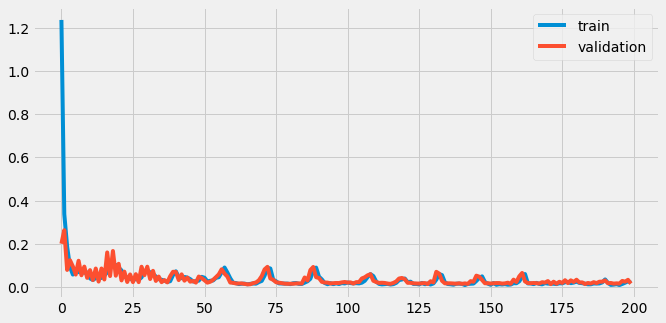

In [350]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.show()

In [351]:
y_predTU = TUcnn_model.predict(X_test)
y_predTU

1/1 [==============================] - 0s 82ms/step


array([[-0.0128962 ],
       [-0.01242284],
       [ 0.02234464],
       [ 0.03052329],
       [-0.02588973],
       [-0.02338238],
       [-0.02480039],
       [-0.04600213],
       [-0.09565192],
       [-0.11925226],
       [-0.11066308],
       [-0.0964523 ],
       [-0.1163192 ],
       [-0.11617807],
       [-0.10387967],
       [-0.13025609],
       [-0.14034875],
       [-0.04693694],
       [ 0.04161637],
       [ 0.0622838 ],
       [-0.03280625],
       [-0.01545106]], dtype=float32)

In [352]:
y_predTU.reshape(1,-1)

array([[-0.0128962 , -0.01242284,  0.02234464,  0.03052329, -0.02588973,
        -0.02338238, -0.02480039, -0.04600213, -0.09565192, -0.11925226,
        -0.11066308, -0.0964523 , -0.1163192 , -0.11617807, -0.10387967,
        -0.13025609, -0.14034875, -0.04693694,  0.04161637,  0.0622838 ,
        -0.03280625, -0.01545106]], dtype=float32)

###Invert Transformed Tuned Data

In [353]:
y_train_inv = cpo_pri_transformer.inverse_transform(y_train.reshape(1, -1))
y_test_inv = cpo_pri_transformer.inverse_transform(y_test.reshape(1, -1))
y_pred_inv = cpo_pri_transformer.inverse_transform(y_predTU.reshape(1,-1))
print(y_train_inv)
print(y_test_inv)
print(y_pred_inv)

[[376. 383. 382. 396. 402. 390. 404. 382. 382. 391. 396. 413. 401. 410.
  425. 408. 392. 371. 356. 362. 356. 352. 333. 357. 411. 404. 387. 395.
  434. 488. 508. 494. 575. 614. 616. 707. 719. 655. 661. 687. 625. 611.
  631. 655. 616. 586. 615. 607. 590. 535. 518. 519. 562. 552. 508. 476.
  513. 545. 532. 550. 561. 567. 580. 559. 562. 553. 533. 498. 504. 525.
  547. 556. 566. 621. 659. 671. 688. 705. 633. 661. 674. 703. 694. 681.
  663. 632. 561. 497. 509. 475. 392. 319. 354. 388. 381. 370.]]
[[349. 372. 324. 315. 312. 306. 288. 255. 257. 265. 254. 240. 254. 251.
  234. 255. 330. 362. 310. 277. 323. 360.]]
[[313.84152 314.03085 327.93787 331.20932 308.6441  309.64703 309.07983
  300.59915 280.73923 271.2991  274.73477 280.4191  272.47232 272.52878
  277.44812 266.89755 262.8605  300.22522 335.64655 343.91354 305.8775
  312.81958]]


In [354]:
y_train_inv = y_train_inv.flatten()
y_train_inv

array([376., 383., 382., 396., 402., 390., 404., 382., 382., 391., 396.,
       413., 401., 410., 425., 408., 392., 371., 356., 362., 356., 352.,
       333., 357., 411., 404., 387., 395., 434., 488., 508., 494., 575.,
       614., 616., 707., 719., 655., 661., 687., 625., 611., 631., 655.,
       616., 586., 615., 607., 590., 535., 518., 519., 562., 552., 508.,
       476., 513., 545., 532., 550., 561., 567., 580., 559., 562., 553.,
       533., 498., 504., 525., 547., 556., 566., 621., 659., 671., 688.,
       705., 633., 661., 674., 703., 694., 681., 663., 632., 561., 497.,
       509., 475., 392., 319., 354., 388., 381., 370.])

In [355]:
y_test_inv = y_test_inv.flatten()
y_test_inv

array([349., 372., 324., 315., 312., 306., 288., 255., 257., 265., 254.,
       240., 254., 251., 234., 255., 330., 362., 310., 277., 323., 360.])

In [356]:
y_pred_inv = y_pred_inv.flatten()
y_pred_inv

array([313.84152, 314.03085, 327.93787, 331.20932, 308.6441 , 309.64703,
       309.07983, 300.59915, 280.73923, 271.2991 , 274.73477, 280.4191 ,
       272.47232, 272.52878, 277.44812, 266.89755, 262.8605 , 300.22522,
       335.64655, 343.91354, 305.8775 , 312.81958], dtype=float32)

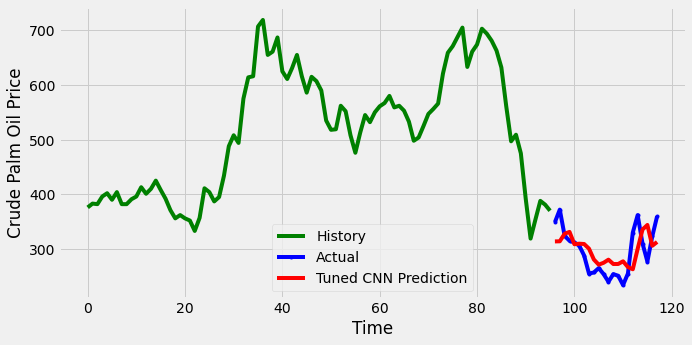

In [357]:
plt.plot(np.arange(0, len(y_train)), y_train_inv, color='green', label="History")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test_inv, color='blue', marker='.', label="Actual")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_pred_inv, color='red', label="Tuned CNN Prediction")
plt.ylabel('Crude Palm Oil Price')
plt.xlabel('Time')
plt.legend()
plt.show();

In [358]:
TURMSE_cnn = mean_squared_error(y_test_inv,y_pred_inv, squared=False)
print('RMSE value of the CNN Model is:', TURMSE_cnn)

RMSE value of the CNN Model is: 36.245400273608475


In [200]:
TUMAE_cnn = mean_absolute_error(y_test_inv, y_pred_inv)
print('MAE value of the CNN Model is:', TUMAE_cnn)

'''
MDA_cnn = mda(y_test_inv, y_pred_inv)
print('MDA value of the CNN Model is:', MDA_cnn)

MAPE_cnn = mean_absolute_percentage_error(y_test_inv, y_pred_inv)
print('MAPE value of the CNN Model is:', MAPE_cnn)

RMSE_cnn = mean_squared_error(y_test_inv,y_pred_inv, squared=False)
print('RMSE value of the CNN Model is:', RMSE_cnn)

MSE_cnn = mean_squared_error(y_test_inv,y_pred_inv)
print('MSE value of the CNN Model is:', MSE_cnn)

#EVS_cnn = explained_variance_score(y_test_inv, y_pred_inv)
#print('EVS score of the CNN Model is:', EVS_cnn)
'''

MAE value of the CNN Model is: 34.13608065518466


"\nMDA_cnn = mda(y_test_inv, y_pred_inv)\nprint('MDA value of the CNN Model is:', MDA_cnn)\n\nMAPE_cnn = mean_absolute_percentage_error(y_test_inv, y_pred_inv)\nprint('MAPE value of the CNN Model is:', MAPE_cnn)\n\nRMSE_cnn = mean_squared_error(y_test_inv,y_pred_inv, squared=False)\nprint('RMSE value of the CNN Model is:', RMSE_cnn)\n\nMSE_cnn = mean_squared_error(y_test_inv,y_pred_inv)\nprint('MSE value of the CNN Model is:', MSE_cnn)\n\n#EVS_cnn = explained_variance_score(y_test_inv, y_pred_inv)\n#print('EVS score of the CNN Model is:', EVS_cnn)\n"

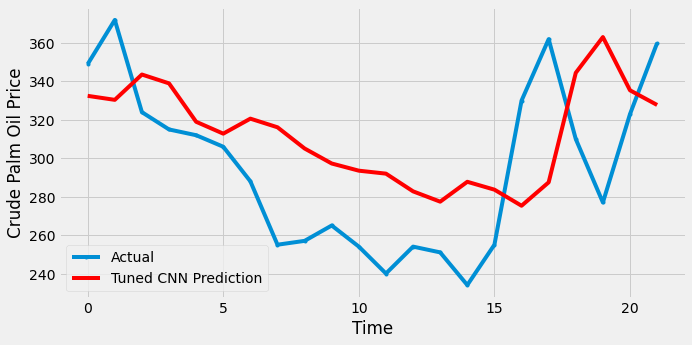

In [346]:
plt.plot(y_test_inv, marker='.', label="Actual")
plt.plot(y_pred_inv, color='red', label="Tuned CNN Prediction")
plt.ylabel('Crude Palm Oil Price')
plt.xlabel('Time')
plt.legend()
plt.show();